In [35]:
# **Imports**
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, TimeDistributed, SimpleRNN, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator 
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from keras.callbacks import EarlyStopping

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

# Loading and Preparing the data

## Loading the Data 

In [4]:
# uploading the files to GC in order to use them. If you use the file in GCP more often, use a DIFFERENT method like connecting to your Drive, like shown below.
#from google.colab import files
#uploaded1 = files.upload()

In [5]:
#uploaded2 = files.upload()

In [2]:
local_path_target = '/mnt/g/Meine Ablage/raw_data/Target/Hourly/energy_generation_data/df_deutschland.csv'

local_path_feature = "/mnt/g/Meine Ablage/raw_data/Features/DATAFRAMES/hourly_globalradiation_df.csv"

data_target = pd.read_csv(local_path_target)
data_feature = pd.read_csv(local_path_feature)

#data_target = pd.read_csv('/content/drive/MyDrive/raw_data/Target/Hourly/energy_generation_data/df_deutschland.csv')
#data_feature = pd.read_csv('/content/drive/MyDrive/raw_data/Features/DATAFRAMES/hourly_globalradiation_df.csv', index_col=0)

data_target['Date'] = pd.to_datetime(data_target.Date)

In [6]:
generation_df = data_target.groupby(by=data_target['Date']).sum()
generation_df.head(3)

,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh]
Date,,,
2015-01-01 00:00:00,517.0,8129.0,0.0
2015-01-01 01:00:00,516.0,8300.0,0.0
2015-01-01 02:00:00,514.0,8544.0,0.0


In [7]:
solar_df = generation_df["Photovoltaics[MWh]"]
solar_df.tail(3)

Date
2021-04-30 21:00:00    0.0
2021-04-30 22:00:00    0.0
2021-04-30 23:00:00    0.0
Name: Photovoltaics[MWh], dtype: float64

In [8]:
data_feature.tail(3)

,Date,164,183,198,232,282,342,427,430,433,...,6197,7351,7367,7368,7369,7370,7374,13674,15000,15818
11661,2021-04-30 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11662,2021-04-30 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11663,2021-04-30 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Is Clouddata maybe better?


# Statistical Exploration

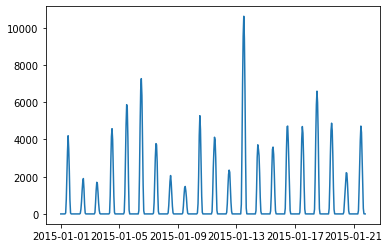

In [10]:
plt.plot(solar_df[:500])

<AxesSubplot:>

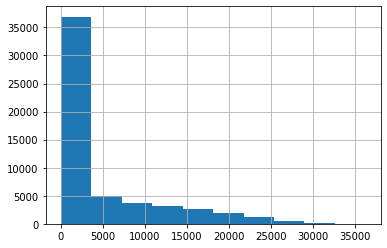

In [11]:
solar_df.hist()

In [12]:
# p-value (should be less than 0.05 to be sattionary)
from statsmodels.tsa.stattools import adfuller

adfuller(solar_df)[1]

2.7855963309276302e-15

In [13]:
# Analyzing seasonality and 

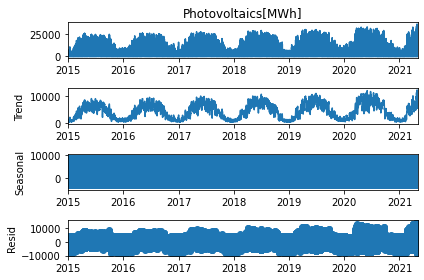

In [14]:


from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(solar_df, model='additive')
result_add.plot();

## Preparing the Data




### Concatenating the Data

In [15]:
solar_df.drop(solar_df.head(solar_df.shape[0]-data_feature.shape[0]).index,inplace=True)

In [16]:
# Building one DataFrame to make the correlation Analysis

complete_df = pd.concat([solar_df, data_feature.set_index(solar_df.index)], axis=1)
complete_df.shape

(11664, 121)

### Filtering the data with highly correlated timeseries Optional 

In [17]:
# Correlation Analysis
#complete_df.corr()

In [18]:
df_corr = complete_df.corr().abs()

In [19]:
df_corr

,Photovoltaics[MWh],164,183,198,232,282,342,427,430,433,...,6197,7351,7367,7368,7369,7370,7374,13674,15000,15818
Photovoltaics[MWh],1.000000,0.781508,0.780628,0.839778,0.830101,0.845172,0.813199,0.800804,0.794589,0.791675,...,0.829469,0.776425,0.808242,0.845927,0.281130,0.809716,0.846881,0.873554,0.864202,0.023892
164,0.781508,1.000000,0.899513,0.876090,0.839640,0.850496,0.833806,0.941742,0.946814,0.928458,...,0.859577,0.949607,0.851946,0.864590,0.247835,0.826521,0.851666,0.848919,0.844615,0.018547
183,0.780628,0.899513,1.000000,0.840640,0.813387,0.827059,0.820424,0.881467,0.886795,0.858027,...,0.847147,0.902628,0.825470,0.839218,0.216594,0.799182,0.846185,0.834866,0.836177,0.011232
198,0.839778,0.876090,0.840640,1.000000,0.865342,0.904928,0.859467,0.895249,0.894762,0.883955,...,0.903108,0.859744,0.890518,0.941870,0.276545,0.863922,0.876235,0.889968,0.881841,0.032900
232,0.830101,0.839640,0.813387,0.865342,1.000000,0.902834,0.801335,0.849465,0.843752,0.842224,...,0.839016,0.826825,0.815335,0.878821,0.305669,0.894854,0.835375,0.910070,0.851534,0.033377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7370,0.809716,0.826521,0.799182,0.863922,0.894854,0.904904,0.801545,0.842155,0.836392,0.839663,...,0.829670,0.807996,0.806754,0.874866,0.266960,1.000000,0.813704,0.882354,0.833913,0.033544
7374,0.846881,0.851666,0.846185,0.876235,0.835375,0.865292,0.900189,0.859910,0.860118,0.850372,...,0.910855,0.857136,0.879187,0.880212,0.255169,0.813704,1.000000,0.874462,0.917821,0.008949
13674,0.873554,0.848919,0.834866,0.889968,0.910070,0.926497,0.846657,0.866184,0.861768,0.858877,...,0.877869,0.841935,0.853509,0.911956,0.261014,0.882354,0.874462,1.000000,0.899300,0.030639
15000,0.864202,0.844615,0.836177,0.881841,0.851534,0.881167,0.876804,0.857512,0.851888,0.847752,...,0.905574,0.846230,0.881077,0.900687,0.242331,0.833913,0.917821,0.899300,1.000000,0.013615


In [20]:
sorted_corr = df_corr.iloc[0].sort_values(ascending=False)
pd.DataFrame(sorted_corr)

,Photovoltaics[MWh]
Photovoltaics[MWh],1.000000
13674,0.873554
4177,0.866014
3660,0.866013
15000,0.864202
...,...
5142,0.758694
3946,0.634170
656,0.339278
7369,0.281130


In [21]:
list_of_corr_060 = list(sorted_corr[sorted_corr >= 0.6].index)

In [22]:
filtered_df = complete_df[list_of_corr_060]

In [23]:
filtered_df

,Photovoltaics[MWh],13674,4177,3660,15000,4336,460,5100,5906,3098,...,183,1605,1684,7351,5792,1757,1503,4104,5142,3946
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30 19:00:00,1104.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-04-30 20:00:00,111.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-04-30 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Scaling the Data

In [24]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(filtered_df)

In [174]:
scaler_y = MinMaxScaler()
scaled_y = scaler_y.fit_transform(pd.DataFrame(solar_df))

In [ ]:
np.asmatrix(scaled)

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

## Forming the Sequences for RNN

In [26]:
prediction_length = 96

In [189]:
# Trying something new with scalers differently applied to features and target

# Train_Data
trainX = scaled[:int(len(scaled)*0.8),:]
trainy = scaled_y[:int(len(scaled)*0.8),:]
# validation Data
valX = scaled[int(len(scaled)-2337):len(scaled)-96,:]
valy = scaled_y[int(len(scaled)-2337):len(scaled)-96,:]
# Test Data
X_test = np.expand_dims(scaled[len(scaled)-prediction_length:,:], axis=0)
y_test = scaled_y[len(scaled)-prediction_length:,:]

In [190]:
trainy = trainy.reshape(-1,1)
valy = valy.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [191]:
y_test.shape

(96, 1)

In [192]:
# Implementing timeseries_dataset_from_array
sequence_length = 500
batch_size=64
start_index=None
end_index=None

In [193]:
train_array = timeseries_dataset_from_array(trainX, trainy,sequence_stride=10, sampling_rate=1,
                                            sequence_length = sequence_length, 
                                            batch_size = batch_size, 
                                            shuffle=False)

In [194]:
validation_array = timeseries_dataset_from_array(valX, valy,sequence_stride=10, sampling_rate=1,
                                            sequence_length = sequence_length, 
                                            batch_size = batch_size, 
                                            shuffle=False)

In [195]:
#test_array = timeseries_dataset_from_array(X_test,y_test, sampling_rate=1,
                                            #sequence_length = 335, 
                                            #batch_size = 1, 
                                            #shuffle=False)

In [196]:
train_array

<BatchDataset shapes: ((None, None, 117), (None, 1)), types: (tf.float64, tf.float64)>

In [197]:
for batch in train_array.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)


Input shape: (64, 500, 117)
Target shape: (64, 1)


In [198]:
inputs.numpy().shape[2]

117

# Model_1 , LSTM Model

In [ ]:
#Do I need to normalize the Data?

# First Model guess
# input_dim=1 because we have only wind speed feature
# RELU because provides only values above 0, we cannot get - generation data - Try Tanh and Sigmoid too in later tries
# **Last Layer** layers.Dense(336) because we have 336 hours in the 2 week prediction. Or do I put 1 because I have 1 X for every output. 
# 
# "linear" According to LEcture has to be like that for regression
# COMPILE LAYER for regression problem: 
# loss='mse', 
# optimizer='adam', (to start with) Choose SGD AND RMSProp(good for RNN) for further testing
# metrics=['mae', "mse"]) (we can use muliple metrics in order to compare)

# 2 units because the time aspect of the series does not have much prediction value. Better to emphasize feature data.

# Try stacked Layers 1,2,3,4

model_1 = Sequential()
model_1.add(LSTM(128,input_shape=(sequence_length,inputs.numpy().shape[2]),return_sequences=True ))
model_1.add(layers.LeakyReLU(alpha=0.5))
#model_1.add(LSTM(128, return_sequences=True))
#model_1.add(layers.LeakyReLU(alpha=0.5))
#model_1.add(layers.Dropout(0.3))
#model_1.add(LSTM(128, return_sequences=True))
model_1.add(layers.Dropout(0.3))
model_1.add(layers.Dense(1))


In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 500, 128)          125952    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 500, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 500, 128)          0         
_________________________________________________________________
dense (Dense)                (None, 500, 1)            129       
Total params: 126,081
Trainable params: 126,081
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_array

<BatchDataset shapes: ((None, None, 117), (None, 1)), types: (tf.float64, tf.float64)>

In [ ]:
es = [EarlyStopping(monitor="val_loss", mode='min', patience = 30, restore_best_weights=True)] 

model_1.compile(loss='mse', optimizer='adam', metrics=['mae', "mse"])

history = model_1.fit(train_array,validation_data=validation_array , shuffle = False,  callbacks = es, epochs=100, verbose=2)


Epoch 1/100
7/7 - 28s - loss: 0.0420 - mae: 0.1364 - mse: 0.0420 - val_loss: 0.0936 - val_mae: 0.2399 - val_mse: 0.0936
Epoch 2/100
7/7 - 7s - loss: 0.0340 - mae: 0.1137 - mse: 0.0340 - val_loss: 0.1268 - val_mae: 0.2707 - val_mse: 0.1268
Epoch 3/100
7/7 - 7s - loss: 0.0374 - mae: 0.1082 - mse: 0.0374 - val_loss: 0.0413 - val_mae: 0.1633 - val_mse: 0.0413
Epoch 4/100
7/7 - 7s - loss: 0.0222 - mae: 0.1089 - mse: 0.0222 - val_loss: 0.0476 - val_mae: 0.1823 - val_mse: 0.0476
Epoch 5/100
7/7 - 7s - loss: 0.0200 - mae: 0.0984 - mse: 0.0200 - val_loss: 0.0424 - val_mae: 0.1432 - val_mse: 0.0424
Epoch 6/100
7/7 - 7s - loss: 0.0199 - mae: 0.0854 - mse: 0.0199 - val_loss: 0.0438 - val_mae: 0.1405 - val_mse: 0.0438
Epoch 7/100
7/7 - 7s - loss: 0.0203 - mae: 0.0894 - mse: 0.0203 - val_loss: 0.0400 - val_mae: 0.1511 - val_mse: 0.0400
Epoch 8/100
7/7 - 7s - loss: 0.0194 - mae: 0.0958 - mse: 0.0194 - val_loss: 0.0397 - val_mae: 0.1549 - val_mse: 0.0397
Epoch 9/100
7/7 - 7s - loss: 0.0189 - mae: 0.09

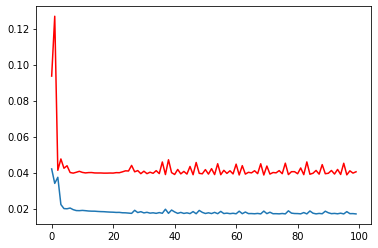

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"], color="red")

In [ ]:
X_test.shape

(1, 96, 117)

In [ ]:
result = model_1.predict(X_test)

In [ ]:
result.shape

(1, 96, 1)

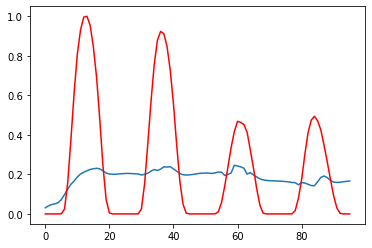

In [ ]:
plt.plot(result.flatten())
plt.plot(y_test, color="red")

# Testing the MAPE score

In [163]:
from sklearn.utils import check_array


def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sum(np.abs(y_true-y_pred))/(len(y_true))

def mse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean((y_true-y_pred)**2)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
res = pd.DataFrame(result.flatten())
res[0]

0     0.030950
1     0.041132
2     0.047307
3     0.051007
4     0.056474
        ...   
91    0.159306
92    0.160585
93    0.162492
94    0.164735
95    0.166386
Name: 0, Length: 96, dtype: float32

In [ ]:

mean_absolute_percentage_error(y_test[1:], res[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


inf

### Unscaling and Comparing

In [ ]:
unscaling_array = scaled_y[:len(scaled_y)-prediction_length]

In [ ]:
unscaling_array = np.append(unscaling_array,result.flatten().reshape(-1,1), axis=0)

In [ ]:
unscaled_results = scaler_y.inverse_transform(unscaling_array)

In [ ]:
plt.plot(unscaled_results[len(unscaled_results)-prediction_length:], color="red")
plt.plot(np.array(solar_df[len(wind_df)-prediction_length:]))

In [ ]:
mean_absolute_percentage_error(wind_df[len(wind_df)-prediction_length:],unscaled_results[len(unscaled_results)-prediction_length:] )

# Sarimax Model

## Forming new sequences

In [232]:
test_length = 336

In [233]:
# Train_Data
trainX2 = scaled[:int(len(scaled)-test_length),:]
trainy2 = scaled_y[:int(len(scaled)-test_length),:]
# validation Data
testX2 = scaled[int(len(scaled)-test_length):,:]
testy2 = scaled_y[int(len(scaled)-test_length):,:]

## Training and predicting with the Model

In [234]:
# Findng the Hyp
#import pmdarima as pm

#smodel = pm.auto_arima(trainy, m=12, X=trainX,
                       #start_p=0, max_p=2,
                       #start_q=0, max_q=5,
                       #max_P=2, max_D=1,max_Q=2,
                       #seasonal=True,
                       #trace=True)

In [235]:
# Order Parameters of best model with exog wind speed and hourly data, non logarithmic data
bm_order = (0,1,0)
# could choose also 24  because sun always has a daily cycle
bm_seasonal_order = (0,0,0,24)

In [236]:
# The model
sarimax = SARIMAX(endog=trainy2, exog=trainX2, order=bm_order, seasonal_order=bm_seasonal_order ).fit()

/home/hauke/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [237]:
#Forecasting
y_pred = sarimax.forecast(testy2.shape[0], exog=testX2, alpha=0.05)

## Unscaling results

In [238]:
unscaling_array_2 = scaled_y[:len(scaled_y)-y_pred.shape[0]]

In [239]:
unscaling_array_tog = np.append(unscaling_array_2,y_pred.flatten().reshape(-1,1), axis=0)

In [240]:
unscaled_results = scaler_y.inverse_transform(unscaling_array_tog)

## MSE & PLot of results

In [241]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(20,8), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

In [242]:
trainy.shape, valy.shape,y_pred.shape

((9331, 1), (2241, 1), (336,))

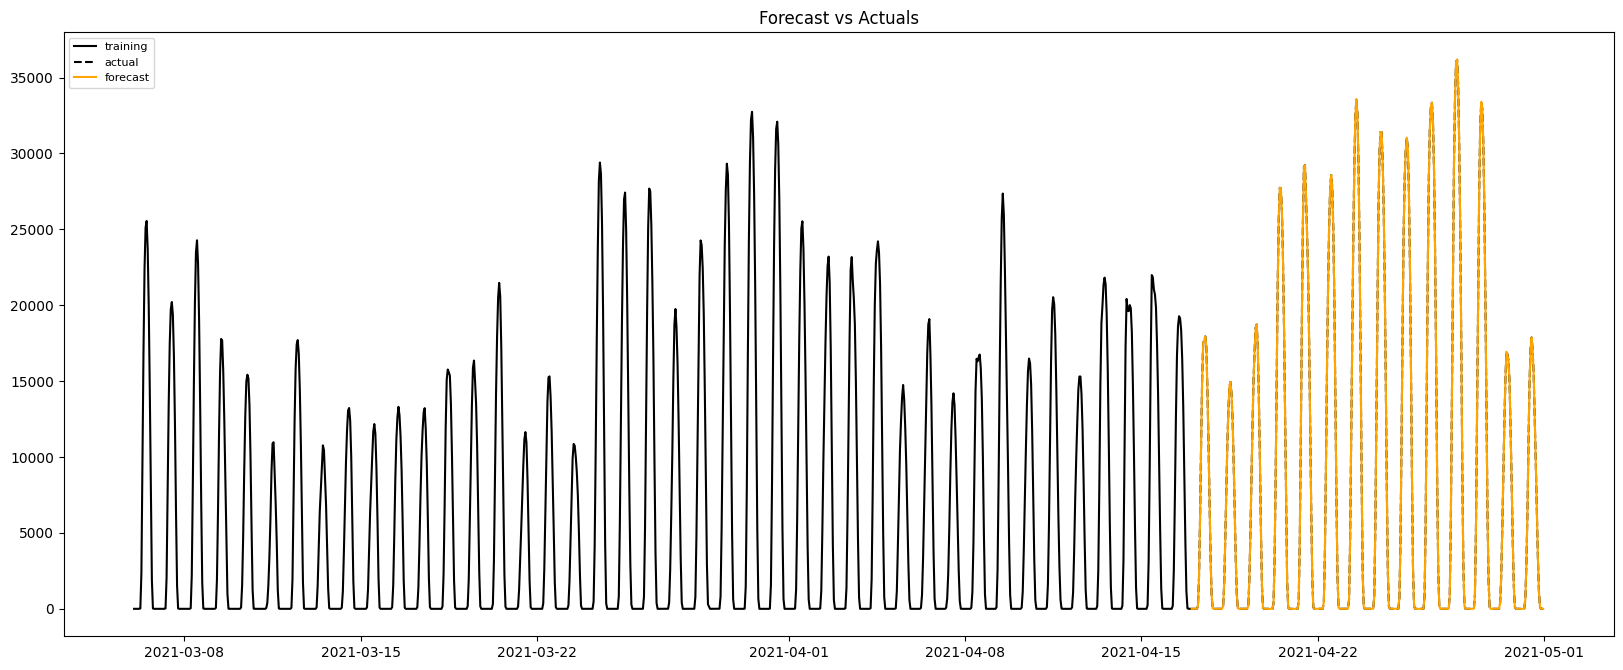

In [243]:
plot_forecast(unscaled_results[len(unscaled_results)-test_length:].flatten()
    , solar_df[len(solar_df)-(test_length*4):len(solar_df)-test_length], solar_df[len(solar_df)-test_length:])

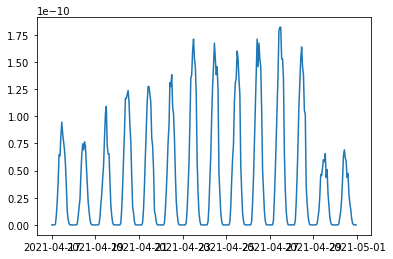

In [244]:
# plotting the residuals

plt.plot(solar_df[len(solar_df)-test_length:] - unscaled_results[len(unscaled_results)-test_length:].flatten())

In [245]:
# THE MAE
mae(solar_df[len(solar_df)-test_length:], unscaled_results[len(unscaled_results)-test_length:].flatten())

4.2182082850024436e-11

In [246]:
solar_df.mean()

4977.531721536351